# Check data quality FROB

2023.4.19 Kurama Okubo

We found that the auto-correlation of BP.FROB shows periodic artificial noise, but the some cross-correlations between FROB and others still works to evaluate the dv/v. Therefore, we check the S/N of FROB, and confirm the quality of ACF and CCF in this notebook.

In [1]:
import datetime
import os
import time
from obspy import read, read_inventory
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import read
from obspy.io.xseed import Parser
from obspy.signal import PPSD
from scipy import signal
from obspy.signal.cross_correlation import correlate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import numpy as np
import matplotlib as mpl

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False

plt.rcParams['axes.linewidth'] = 0.75

In [2]:
fodatadir = "./data"    
figdir = "./figure"

if not os.path.exists(fodatadir):
    os.makedirs(fodatadir)

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
# We download the data from https://service.ncedc.org/fdsnws/dataselect/1/
import requests

sta1 = "FROB"
loc1 = "40"
cha1="SP1"
starttime="2020-04-01T00:00:00"
endtime="2020-04-02T00:00:00"

URL = f"https://service.ncedc.org/fdsnws/dataselect/1/query?net=BP&sta={sta1}&loc={loc1}&cha={cha1}&start={starttime}&end={endtime}"
print(URL)
response = requests.get(URL)
open(f"{fodatadir}/waveform_{sta1}_{loc1}_{cha1}_{starttime}-{endtime}.mseed", "wb").write(response.content)

https://service.ncedc.org/fdsnws/dataselect/1/query?net=BP&sta=FROB&loc=40&cha=SP3&start=2020-04-01T00:00:00&end=2020-04-02T00:00:00


2973696

In [4]:
st = read(f"{fodatadir}/waveform_{sta1}_{loc1}_{cha1}_{starttime}-{endtime}.mseed", format="MSEED")

In [5]:
staxml1_URL = f"https://service.ncedc.org/fdsnws/station/1/query?net=BP&sta={sta1}&cha={cha1}&loc={loc1}&level=response&format=xml&includeavailability=false"
print(staxml1_URL)
response = requests.get(staxml1_URL)
stationxml1 = f"{fodatadir}/resp_{sta1}_{loc1}_{cha1}_{starttime}-{endtime}.xml"
open(stationxml1, "wb").write(response.content) 
     

https://service.ncedc.org/fdsnws/station/1/query?net=BP&sta=FROB&cha=SP3&loc=40&level=response&format=xml&includeavailability=false


194415

/Users/kokubo/opt/miniconda3/envs/obspy3.8/lib/python3.8/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


BP.FROB.40.SP3 | 2020-04-01T00:00:00.000000Z - 2020-04-01T23:59:59.950000Z | 20.0 Hz, 1728000 samples

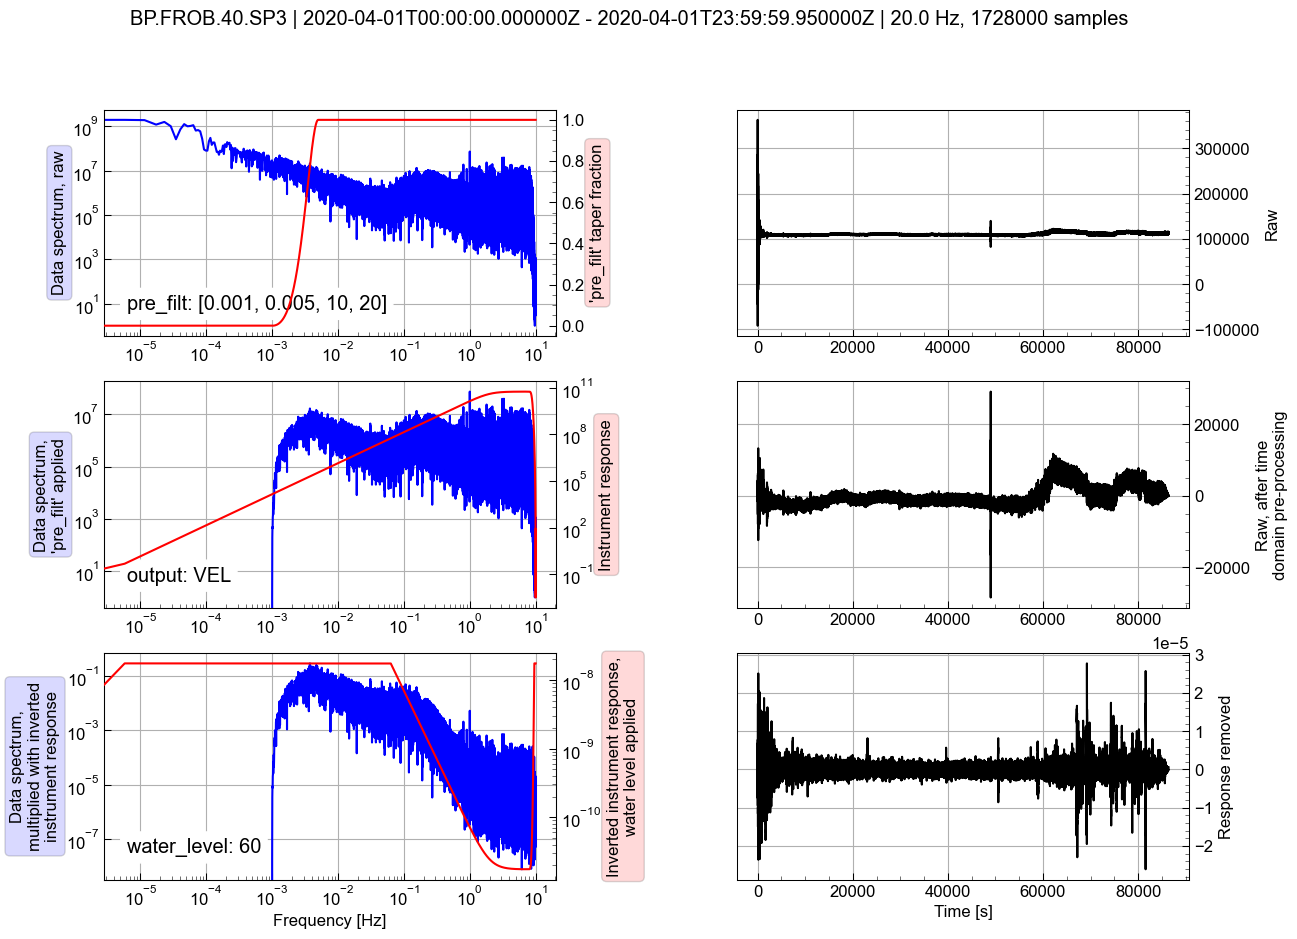

In [6]:
# remove response
tr = st[0].copy()
inv = read_inventory(stationxml1)
pre_filt = [0.001, 0.005, 10, 20]
tr.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL", water_level=60, plot=True)  

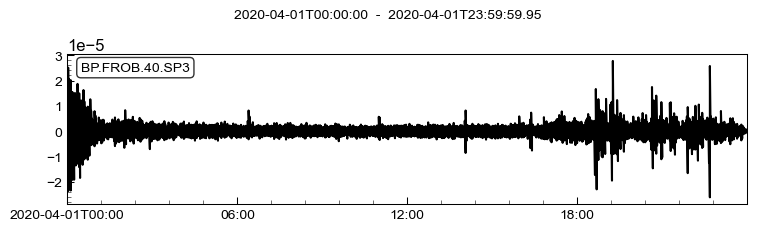

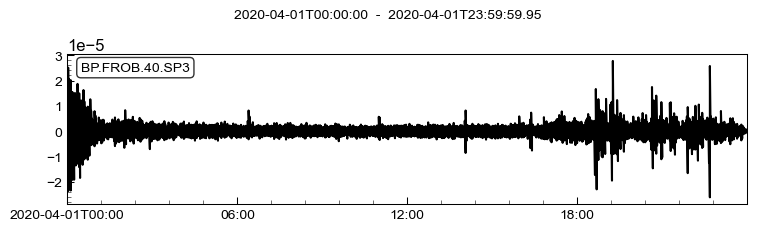

In [7]:
tr.plot()

In [8]:
freqmin = 0.9
freqmax = 1.2
# apply bandpass filter for the target frequency band
tr_filtered = tr.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

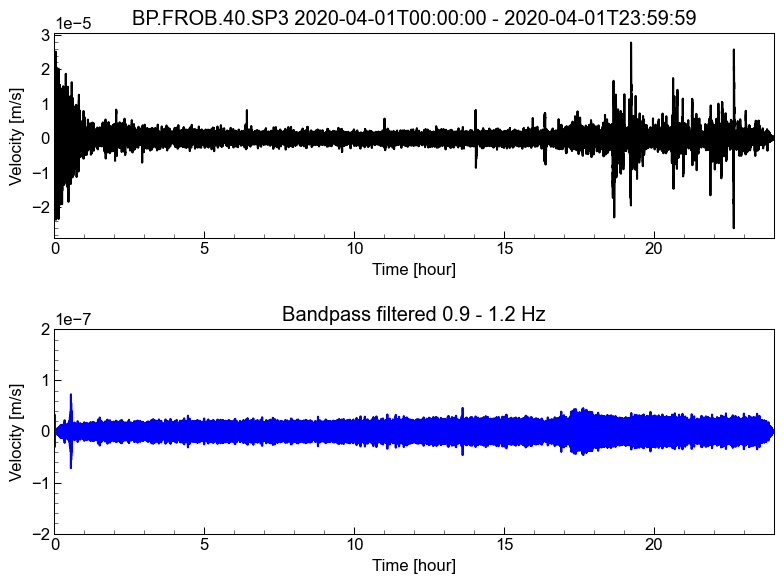

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
tvec = tr.times()
axs[0].plot(tvec/3600, tr.data, "k-");
axs[0].set_xlim([0, 24])
axs[0].set_title(f"{tr.id} {tr.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')} - {tr.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}")
axs[0].set_xlabel("Time [hour]")
axs[0].set_ylabel("Velocity [m/s]")

axs[1].plot(tvec/3600, tr_filtered.data, "b-");
axs[1].set_xlim([0, 24])
axs[1].set_ylim([-2e-7, 2e-7])
axs[1].set_xlabel("Time [hour]")
axs[1].set_ylabel("Velocity [m/s]")
axs[1].set_title(f"Bandpass filtered {freqmin} - {freqmax} Hz")

fig.tight_layout()
plt.subplots_adjust(hspace=0.45, wspace=0.3)
foname = (f"{figdir}/{tr.id}_{tr.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')}-{tr.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}.png")
plt.savefig(foname, dpi=150)



In [10]:
# plot spectrum
tr_psd = tr.copy()
tr_psd.data -= np.mean(tr_psd.data[:]) # demean
tr_psd.taper(type='cosine', max_percentage=0.05) # taper
nFFT_P = int(2**(np.ceil(np.log2(tr_psd.stats.npts))+1))
zeropadded_P = np.zeros(nFFT_P) # zero padding 
zeropadded_P[:tr_psd.stats.npts] = tr_psd.data
NPzeropad = len(zeropadded_P)
freq_p, PF = signal.welch(zeropadded_P, fs=tr_psd.stats.sampling_rate, nperseg=NPzeropad/2**5, scaling='density')


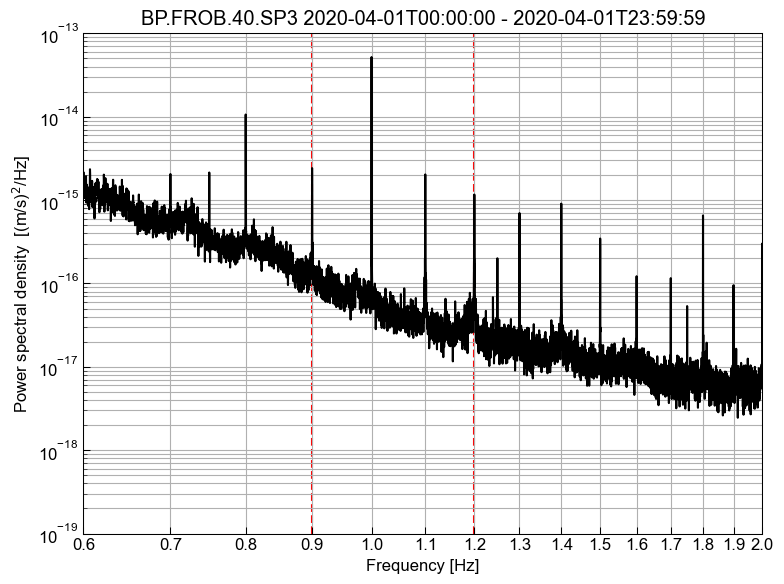

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.grid(which='both')
# axs[0, 1].semilogx(freq_p, 10*np.log10(PF), "k+-")
ax.loglog(freq_p, PF, "k-")
ax.axvline(freqmin, c="r", ls="--", zorder=-1)
ax.axvline(freqmax, c="r", ls="--", zorder=-1)
# ax.axvline(0.92, c="b", ls="--")
# ax.axvline(0.98, c="b", ls="--")

ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"Power spectral density  [(m/s)$^2$/Hz]")
ax.set_title(f"{tr.id} {tr.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')} - {tr.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}")
ax.set_xlim([0.6, 2.0]) #([1, 1e6])
ax.set_ylim([1e-19, 1e-13])

ax.set_xticks(np.hstack([np.linspace(0.6, 1, 5), np.linspace(1.1, 2, 10)]))

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

fig.tight_layout()
plt.subplots_adjust(hspace=0.45, wspace=0.3)
foname = (f"{figdir}/PSD_{tr.id}_{tr.stats.starttime}-{tr.stats.endtime}.png")
plt.savefig(foname, dpi=300)


In [12]:
lagtime = 50.0

freqmin_acf = 0.9
freqmax_acf = 1.2
# apply bandpass filter for the target frequency band
tr_filtered_acf = tr.copy().filter("bandpass", freqmin=freqmin_acf, freqmax=freqmax_acf, corners=6, zerophase=True)

dt = 1/tr_filtered_acf.stats.sampling_rate
tlag = np.arange(-lagtime, lagtime+dt, step=dt)
Nshift = int(lagtime * tr_filtered_acf.stats.sampling_rate)
acf1 = correlate(tr_filtered_acf.data, tr_filtered_acf.data, Nshift, normalize=None)  

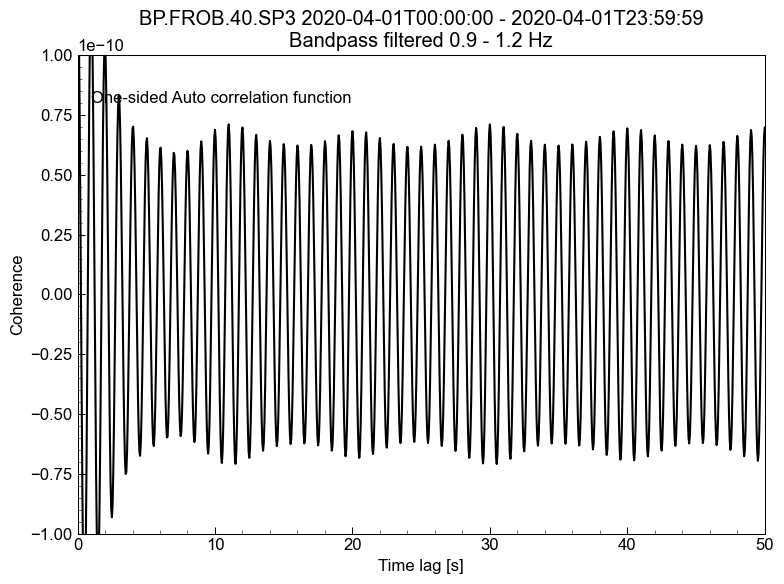

In [13]:
ylimit = [-1e-10, 1e-10]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(tlag, acf1, "k-")
ax.set_xlabel("Time lag [s]")
ax.set_ylabel("Coherence")
ax.set_xlim([0, 50])
ax.set_ylim(ylimit)
ax.set_title(f"{tr.id} {tr.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')} - {tr.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}\nBandpass filtered {freqmin_acf} - {freqmax_acf} Hz")
ax.text(1, 8e-11, "One-sided Auto correlation function")

fig.tight_layout()
plt.subplots_adjust(hspace=0.45, wspace=0.3)
foname = (f"{figdir}/ACFonesided_{tr.id}_{tr.stats.starttime}-{tr.stats.endtime}_{freqmin_acf}-{freqmax_acf}Hz.png")
plt.savefig(foname, dpi=300)


# Check cross-correlation

In [14]:
sta2 = "LCCB"
loc2 = "40"
cha2="SP1"

URL = f"https://service.ncedc.org/fdsnws/dataselect/1/query?net=BP&sta={sta2}&loc={loc2}&cha={cha2}&start={starttime}&end={endtime}"
print(URL)
response = requests.get(URL)
open(f"{fodatadir}/waveform_{sta2}_{loc2}_{cha2}_{starttime}-{endtime}.mseed", "wb").write(response.content)

https://service.ncedc.org/fdsnws/dataselect/1/query?net=BP&sta=LCCB&loc=40&cha=SP1&start=2020-04-01T00:00:00&end=2020-04-02T00:00:00


2486272

In [15]:
st2 = read(f"{fodatadir}/waveform_{sta2}_{loc2}_{cha2}_{starttime}-{endtime}.mseed", format="MSEED")

In [16]:
staxml2_URL = f"https://service.ncedc.org/fdsnws/station/1/query?net=BP&sta={sta2}&cha={cha2}&loc={loc2}&level=response&format=xml&includeavailability=false"
print(staxml2_URL)
response = requests.get(staxml2_URL)
stationxml2 = f"{fodatadir}/resp_{sta2}_{loc2}_{cha2}_{starttime}-{endtime}.xml"
open(stationxml2, "wb").write(response.content) 
     

https://service.ncedc.org/fdsnws/station/1/query?net=BP&sta=LCCB&cha=SP1&loc=40&level=response&format=xml&includeavailability=false


56399

/Users/kokubo/opt/miniconda3/envs/obspy3.8/lib/python3.8/site-packages/obspy/io/stationxml/core.py:91: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  warnings.warn("The StationXML file has version %s, ObsPy can "
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


BP.LCCB.40.SP1 | 2020-04-01T00:00:00.000000Z - 2020-04-01T23:59:59.950000Z | 20.0 Hz, 1728000 samples

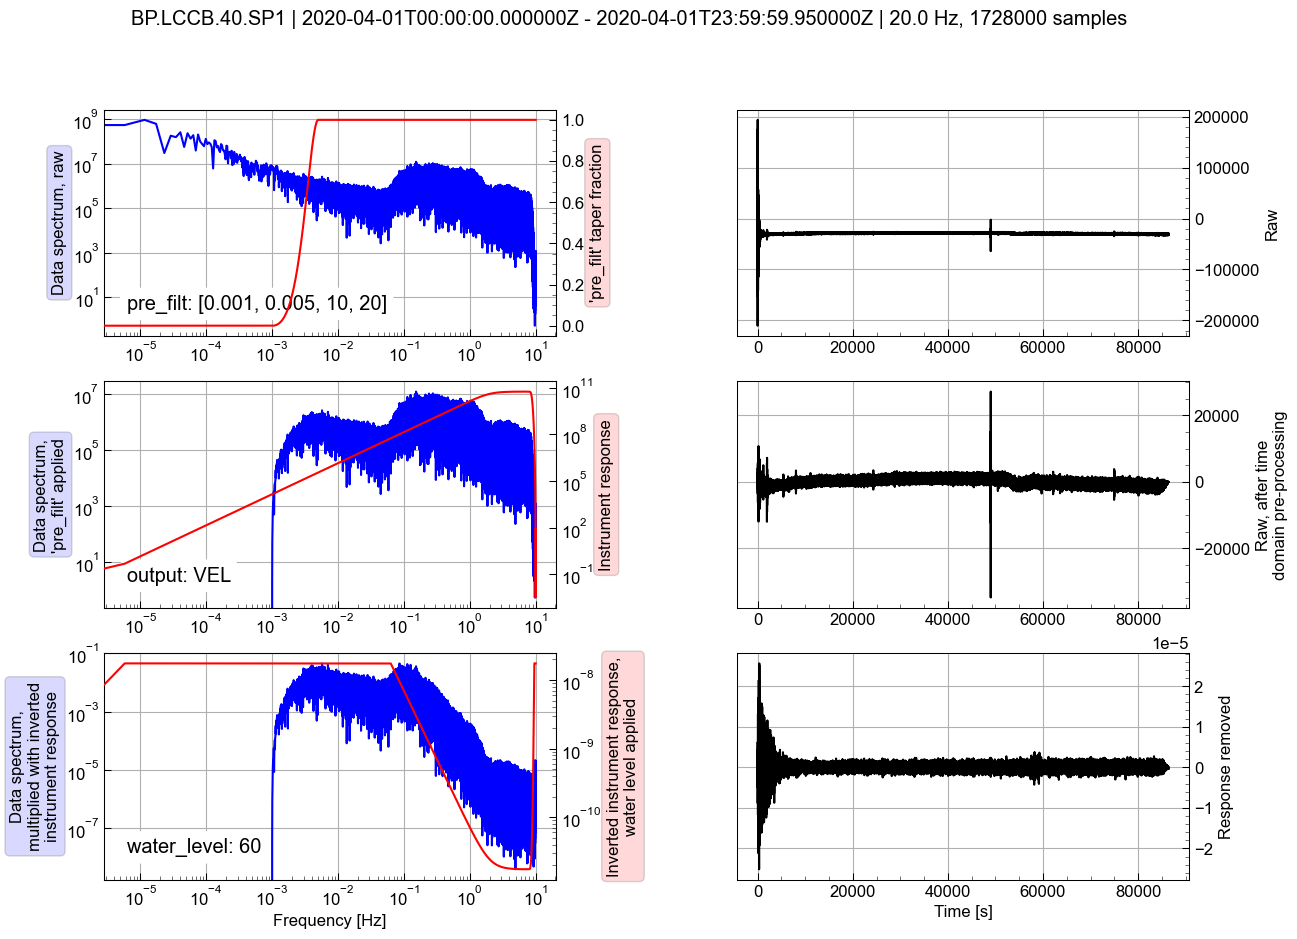

In [17]:
# remove response
tr2 = st2[0].copy()
inv = read_inventory(stationxml2)
pre_filt = [0.001, 0.005, 10, 20]
tr2.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL", water_level=60, plot=True)  

In [18]:
# apply bandpass filter for the target frequency band
tr2_filtered = tr2.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

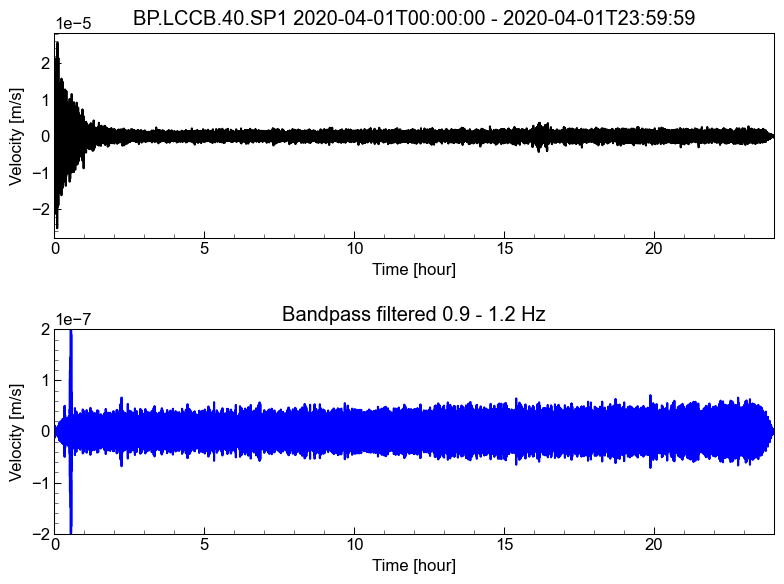

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
tvec = tr2.times()
axs[0].plot(tvec/3600, tr2.data, "k-");
axs[0].set_xlim([0, 24])
axs[0].set_title(f"{tr2.id} {tr2.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')} - {tr2.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}")
axs[0].set_xlabel("Time [hour]")
axs[0].set_ylabel("Velocity [m/s]")

axs[1].plot(tvec/3600, tr2_filtered.data, "b-");
axs[1].set_xlim([0, 24])
axs[1].set_ylim([-2e-7, 2e-7])
axs[1].set_xlabel("Time [hour]")
axs[1].set_ylabel("Velocity [m/s]")
axs[1].set_title(f"Bandpass filtered {freqmin} - {freqmax} Hz")

fig.tight_layout()
plt.subplots_adjust(hspace=0.45, wspace=0.3)
foname = (f"{figdir}/{tr2.id}_{tr2.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')}-{tr2.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}.png")
plt.savefig(foname, dpi=150)



## Compute cross_correlation

In [20]:
freqmin_ccf = 0.9
freqmax_ccf = 1.2
# apply bandpass filter for the target frequency band
tr_filtered_ccf = tr2.copy().filter("bandpass", freqmin=freqmin_acf, freqmax=freqmax_acf, corners=6, zerophase=True)
ccf1 = correlate(tr_filtered_acf.data, tr_filtered_ccf.data, Nshift, normalize=None)  

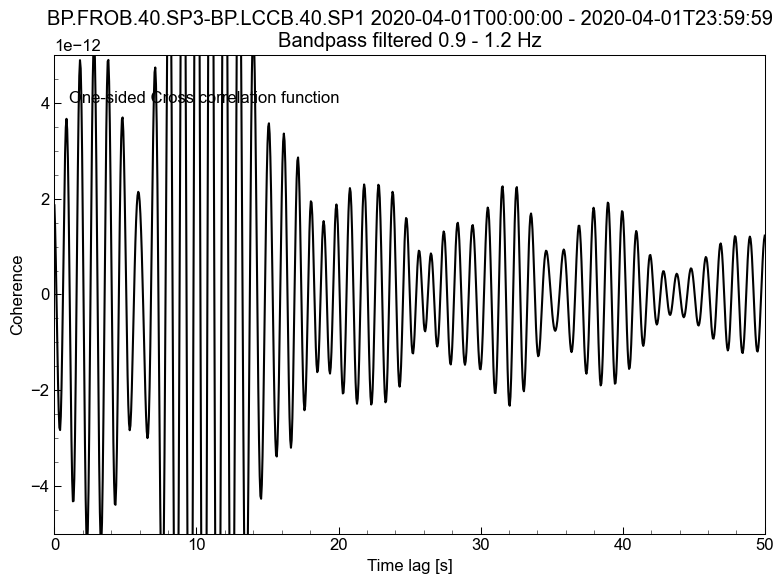

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(tlag, ccf1, "k-")
ax.set_xlabel("Time lag [s]")
ax.set_ylabel("Coherence")
ax.set_xlim([0, 50])
ax.set_ylim(0.05*np.array(ylimit))
ax.set_title(f"{tr_filtered_acf.id}-{tr_filtered_ccf.id} {tr.stats.starttime.strftime('%Y-%m-%dT%H:%M:%S')} - {tr.stats.endtime.strftime('%Y-%m-%dT%H:%M:%S')}\nBandpass filtered {freqmin_ccf} - {freqmax_ccf} Hz")
ax.text(1, 4e-12, "One-sided Cross correlation function")

fig.tight_layout()
plt.subplots_adjust(hspace=0.45, wspace=0.3)
foname = (f"{figdir}/CCFonesided_{tr.id}_{tr.stats.starttime}-{tr.stats.endtime}_{freqmin_acf}-{freqmax_acf}Hz.png")
plt.savefig(foname, dpi=300)
